In [2]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
matplotlib.__version__ # should be 2.0.0 or above

'3.3.1'

# Training Dataset

Let's start with the training datasets. Let's load them all into memory with h5py. You can investigate the structure of these HDF5 files using `h5ls` in your terminal window.

The energy collected by each cell in each calorimeter layer is stored in `layer_0`, `layer_1` and `layer_3`. The initial energy of the incident particle is saved in `energy`, while the `overflow` contains the energy that fell outside the calorimeter portion we are considering.

In [4]:
#d_gamma = h5py.File('../data/gamma.hdf5', 'r')
d_eplus = h5py.File('../QC-CaloGAN/data/eplus.hdf5', 'r')
#d_piplus = h5py.File('../data/piplus.hdf5', 'r')

In [5]:
#gamma_0 = d_gamma['layer_0'][:]
#gamma_1 = d_gamma['layer_1'][:]
#gamma_2 = d_gamma['layer_2'][:]

eplus_0 = d_eplus['layer_0'][:]
eplus_1 = d_eplus['layer_1'][:]
eplus_2 = d_eplus['layer_2'][:]

#piplus_0 = d_piplus['layer_0'][:]
#piplus_1 = d_piplus['layer_1'][:]
#piplus_2 = d_piplus['layer_2'][:]

In [6]:
#real_images_gamma = [gamma_0, gamma_1, gamma_2]
real_images_eplus = [eplus_0, eplus_1, eplus_2]
#real_images_piplus = [piplus_0, piplus_1, piplus_2]

Because of the heterogenous segmentation in eta and phi of each layer of the detector, the images we use to represent the energy deposits in each layer will have different sizes. For convenience later on, we save those sizes in a list.

In [7]:
sizes = [
    eplus_0.shape[1], eplus_0.shape[2],
    eplus_1.shape[1], eplus_1.shape[2],
    eplus_2.shape[1], eplus_2.shape[2]]
print(sizes)

[3, 96, 12, 12, 12, 6]


Just to give you an idea of what these images look like, let's plot the first photon shower.

In [8]:
matplotlib.rcParams.update({'font.size': 50})

In [9]:
def plot_image(image, layer, vmin=None, vmax=None):
    '''
    Args:
    -----
        image: ndarray with energies collected by each calo cell
        layer: int in {0,1,2}, useful to resize image correctly
        vmin: float, min energy to clip at
        vmax: float, max energy to clip at
    '''
    fig = plt.figure(figsize=(20,20))
    im = plt.imshow(image,
               aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest',
               norm=LogNorm(vmin, vmax)
    )
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params()
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])
    if layer == 0:
        xticks = xticks[::10]
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID')
    plt.ylabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    return im

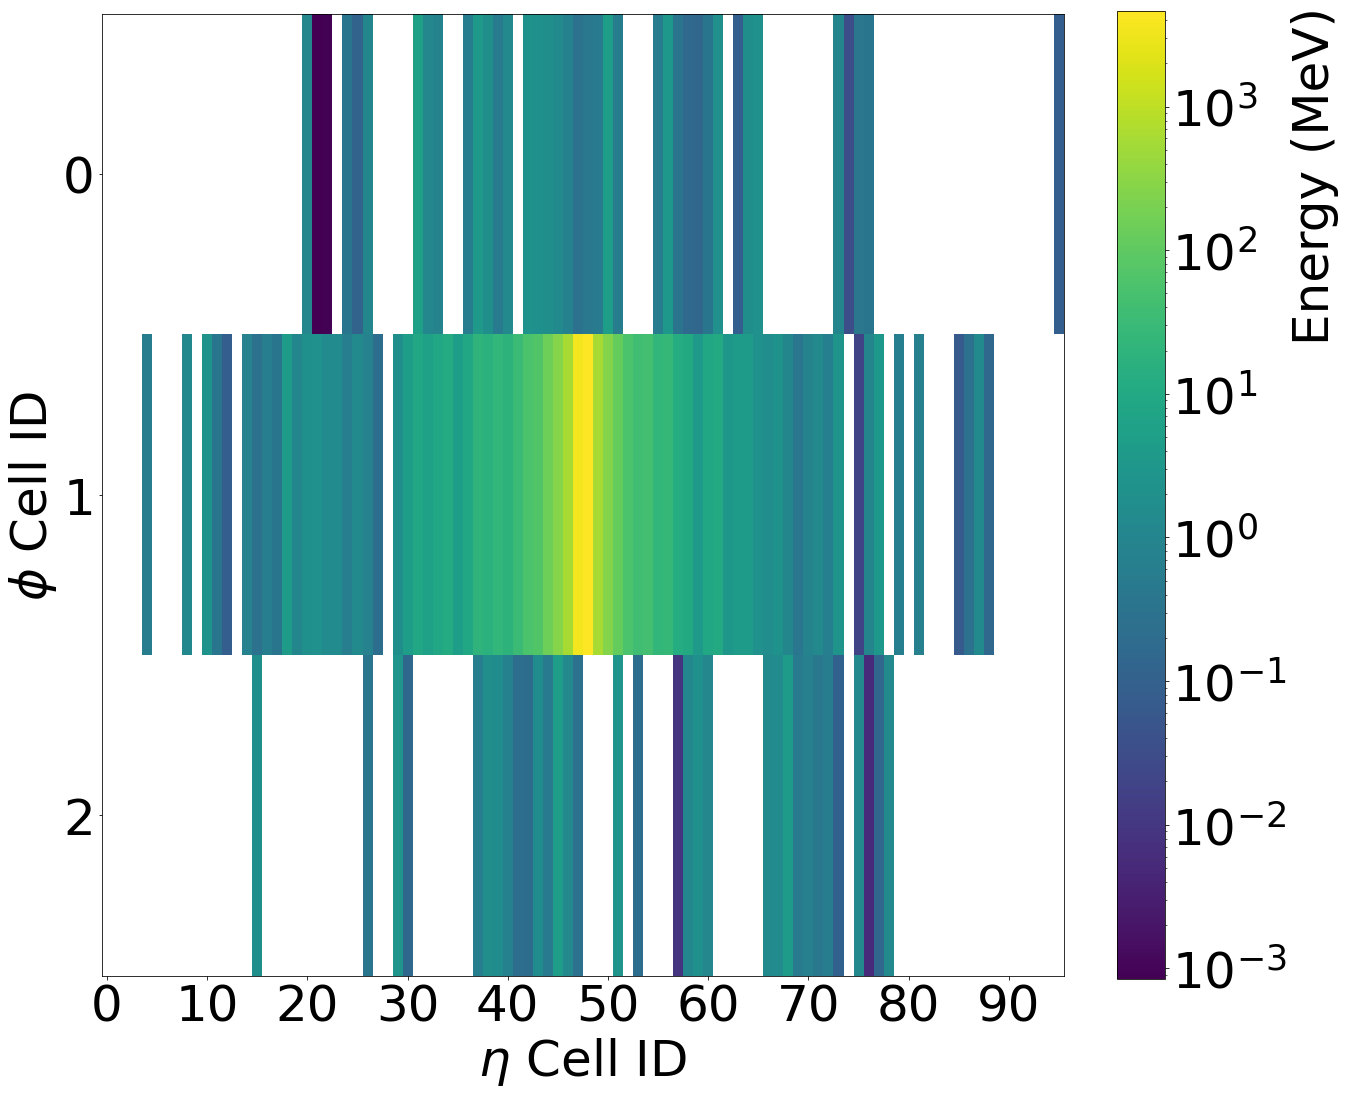

In [10]:
imageix = 0 # let's look at the very first shower
plot_image(eplus_0[imageix], layer=0)

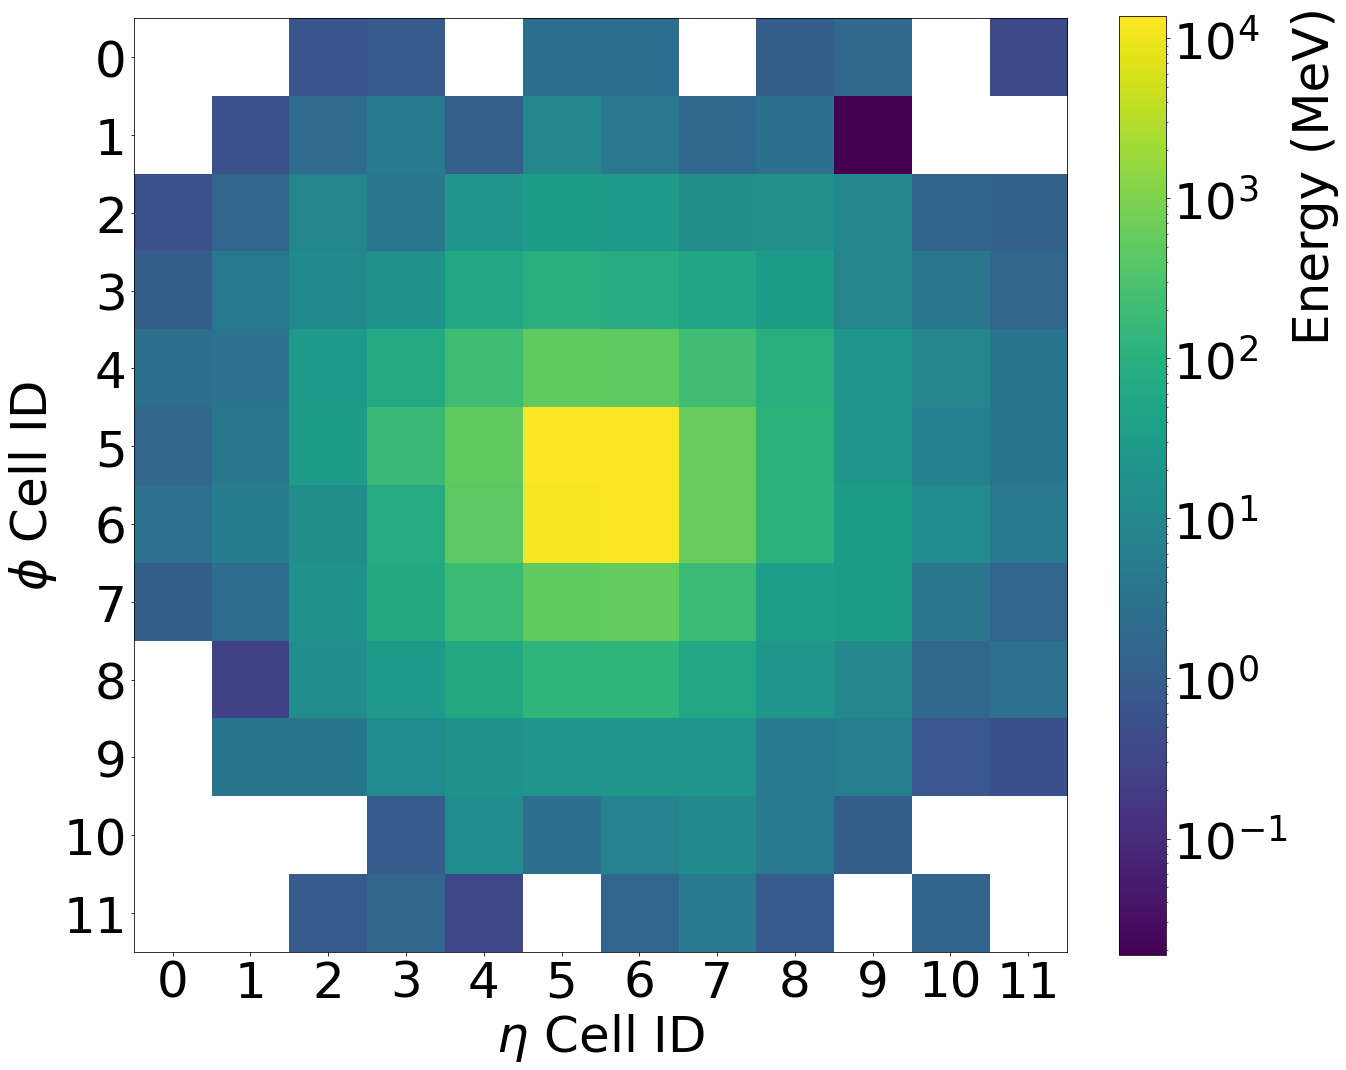

In [11]:
im = plot_image(eplus_1[imageix], layer=1)

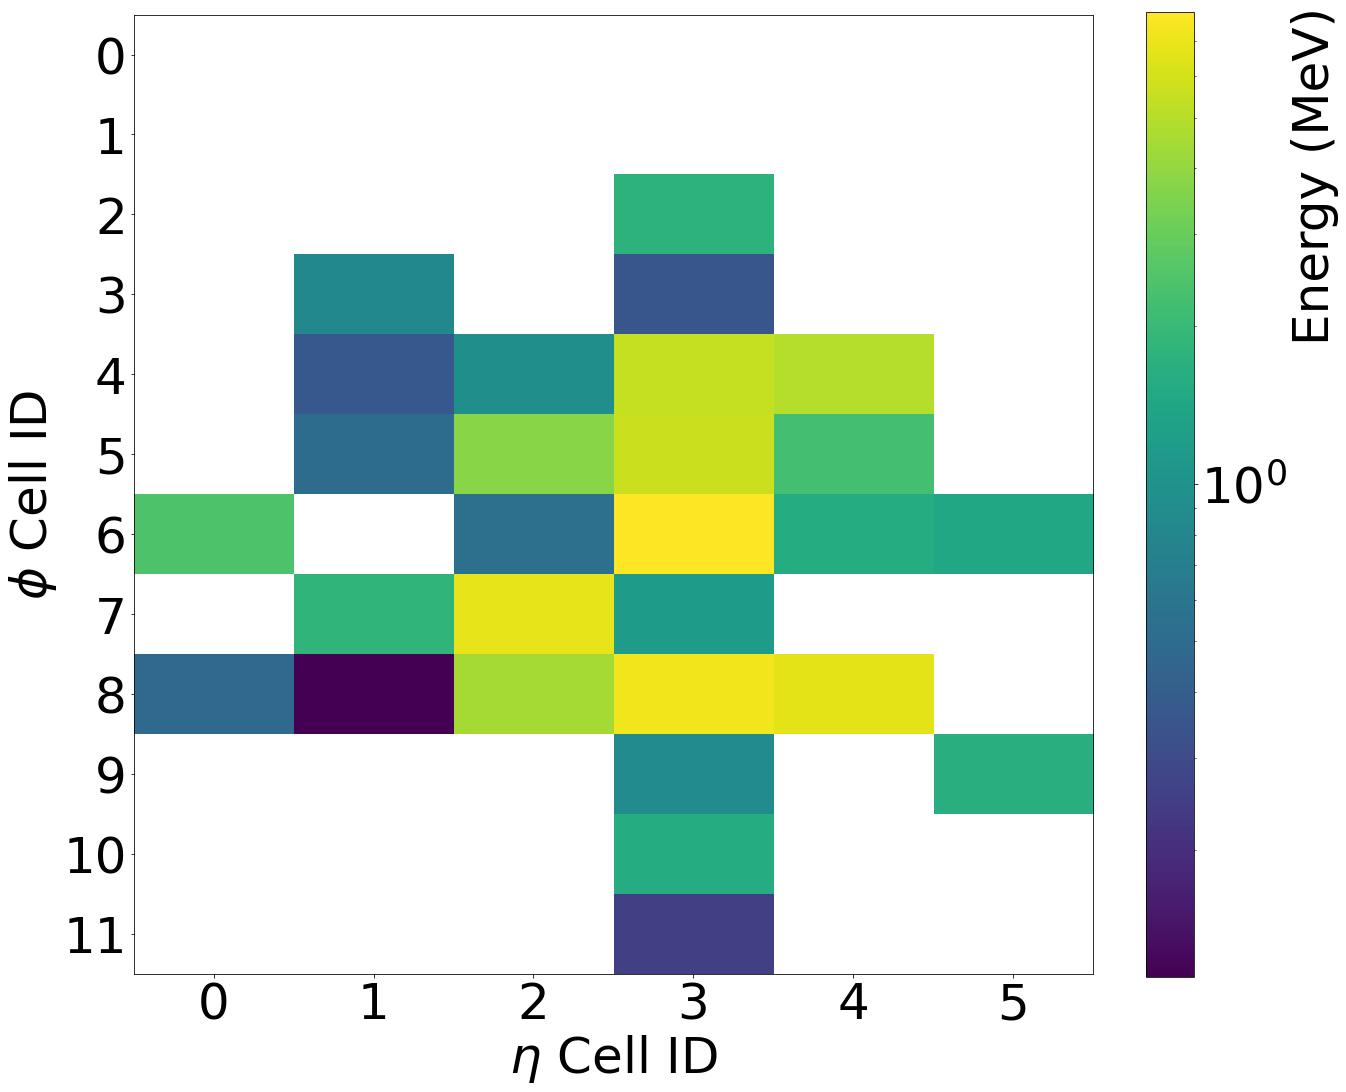

In [12]:
plot_image(eplus_2[imageix], layer=2)

# GAN Sample Generation

Let's build the network architecture we proposed, load its trained weights, and use it to generate synthesized showers. We do all this using `Keras` with the `TensorFlow` backend.

This was our choice for the size of the latent space $z$. If you want to retrain this net, you can try changing this parameter.

In [13]:
latent_size = 2**8 

In [14]:
from tensorflow.keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D, multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [15]:
%cd ../QC-CaloGAN/models/
from architectures import build_generator, build_discriminator,  sparse_softmax
from ops import scale, inpainting_attention
%cd ../../notebooks/

/home/tdhttt/workspace/QC-UCI/QHack/QC-CaloGAN/models
/home/tdhttt/workspace/QC-UCI/QHack/notebooks


In [16]:
# input placeholders
latent = Input(shape=(latent_size, ), name='z') # noise
input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
generator_inputs = [latent, input_energy]

# multiply the (scaled) energy into the latent space
h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# build three LAGAN-style generators (checkout out `build_generator` in architectures.py)
img_layer0 = build_generator(h, 3, 96)
img_layer1 = build_generator(h, 12, 12)
img_layer2 = build_generator(h, 12, 6)

# inpainting
# 0 --> 1
zero2one = AveragePooling2D(pool_size=(1, 8))(
    UpSampling2D(size=(4, 1))(
        img_layer0))
img_layer1 = inpainting_attention(img_layer1, zero2one) # this function is in ops.py
# 1 --> 2
one2two = AveragePooling2D(pool_size=(1, 2))(img_layer1)
img_layer2 = inpainting_attention(img_layer2, one2two)
# ^^ pooling and upsampling are needed to reshape images to same dimensions

# outputs
generator_outputs = [
    Activation('relu')(img_layer0),
    Activation('relu')(img_layer1),
    Activation('relu')(img_layer2)
]

In [17]:
# build the actual model
generator = Model(generator_inputs, generator_outputs)

In [19]:
# load trained weights
generator.load_weights('../QC-CaloGAN/models/weights/exp_classical_gen049.hdf5')

Now that the net is instantiated, we can use it to generate images. To do so, we need to provide inputs. In particular, the latent space expects some normally distributed noise, while the requested energy can be an array of your choice. Our net was trained with an uniform spectrum of energies between 1 and 100 GeV, so it should be safe to request any list of energies in that range. You could also try to request an energy outside of that range and see what happens.

In [20]:
# 10,000 is the number of showers we want to generate right now
noise = np.random.normal(0, 1, (10000, latent_size))
sampled_energy = np.random.uniform(1, 100, (10000, 1))

In [31]:
images = generator.predict([noise, sampled_energy], verbose=True)

313/313 [==============================] - 5s 17ms/step


In [32]:
# we need to multiply images by 1000 to match order of magnitude of generated images to real images
nimages = [np.squeeze(np.array(i) * 1000) for i in images]
#images = map(lambda x: np.squeeze(x * 1000), images)
vmin = [eplus_0.mean(axis=0).min(), eplus_1.mean(axis=0).min(), eplus_2.mean(axis=0).min()]
vmax = [eplus_0.mean(axis=0).max(), eplus_1.mean(axis=0).max(), eplus_2.mean(axis=0).max()]

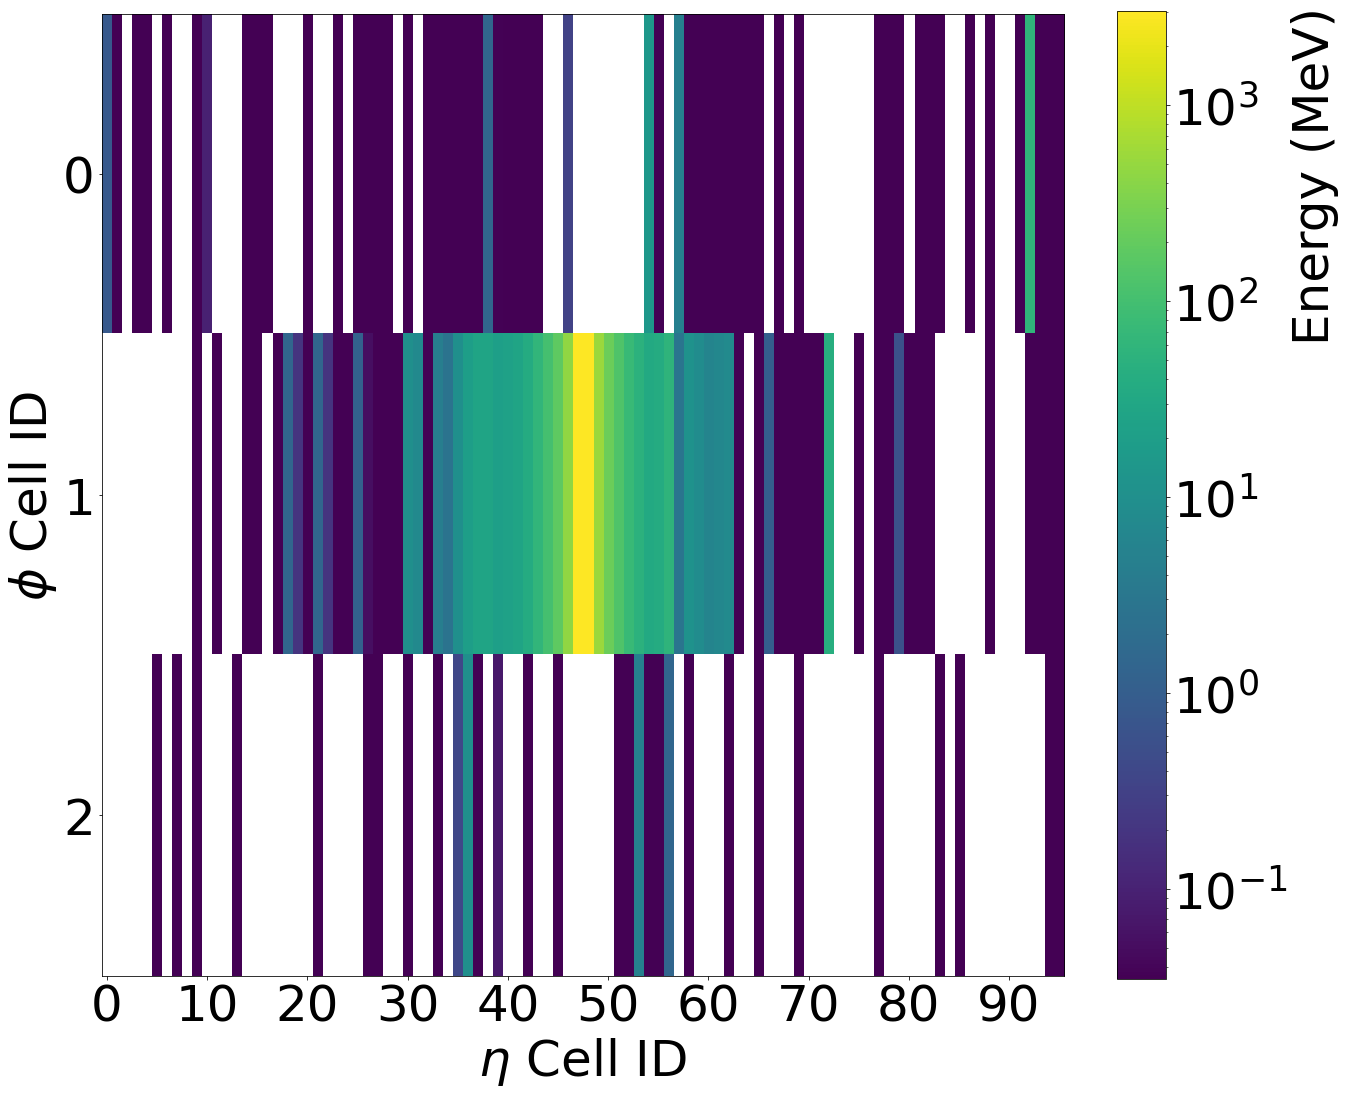

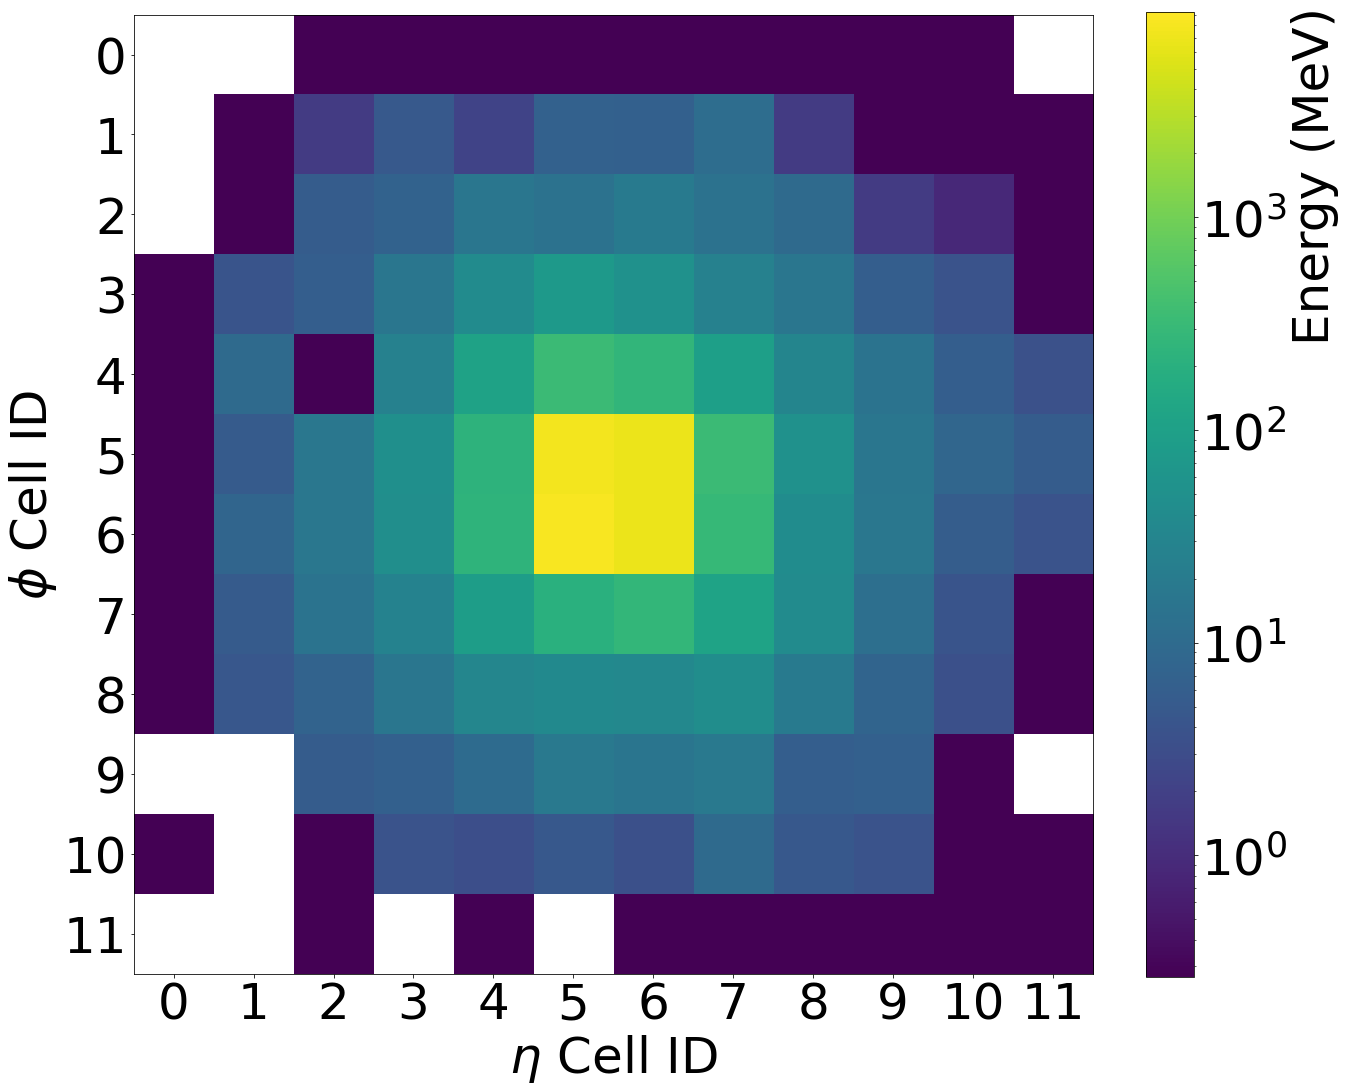

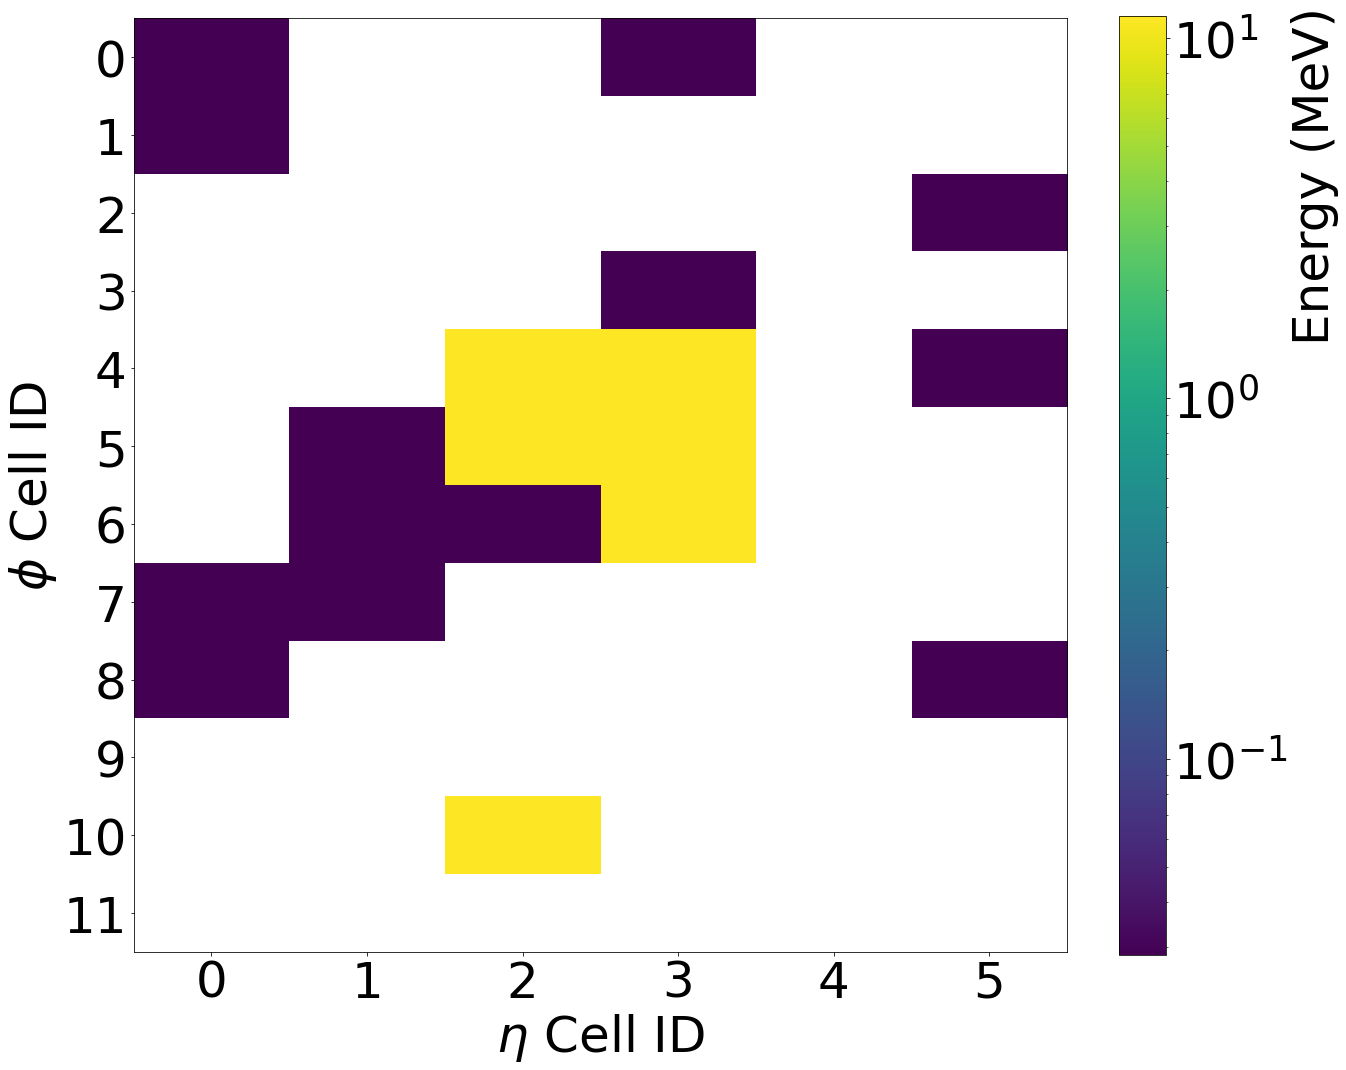

In [33]:
gen_images_eplus = [nimages[0], nimages[1], nimages[2]]
for i in range(3):
    plot_image(np.squeeze(gen_images_eplus[i]).mean(axis=0),
               layer=i,
               vmin=vmin[i],
               vmax=vmax[i]
    )
    #plt.savefig('eplus_{}.pdf'.format(i), transparent=True)

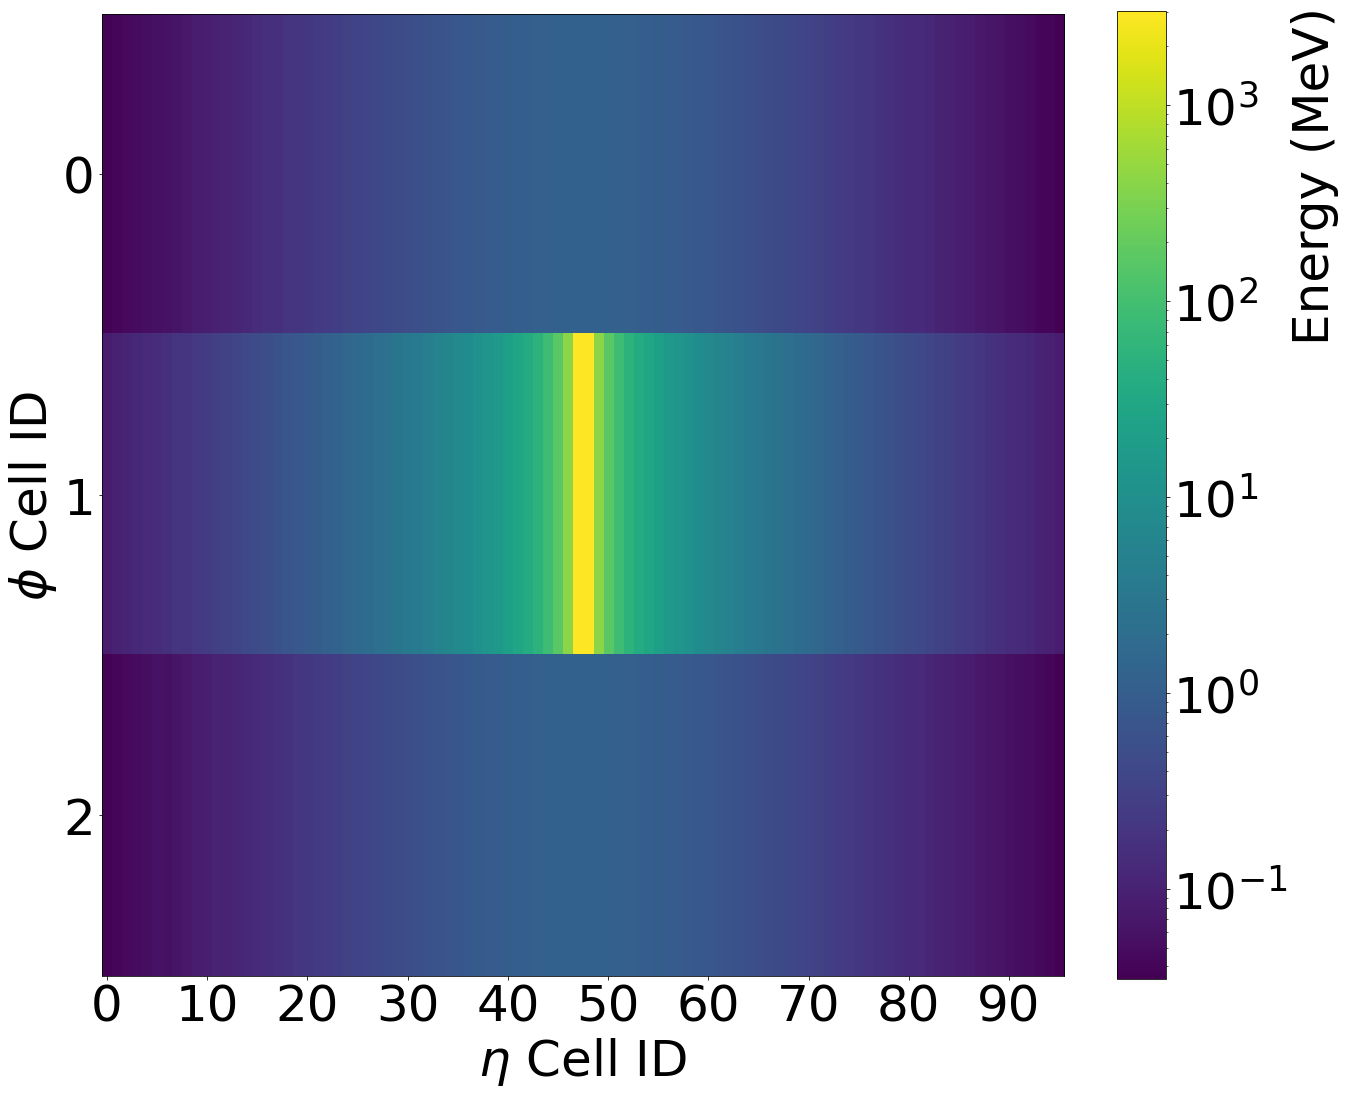

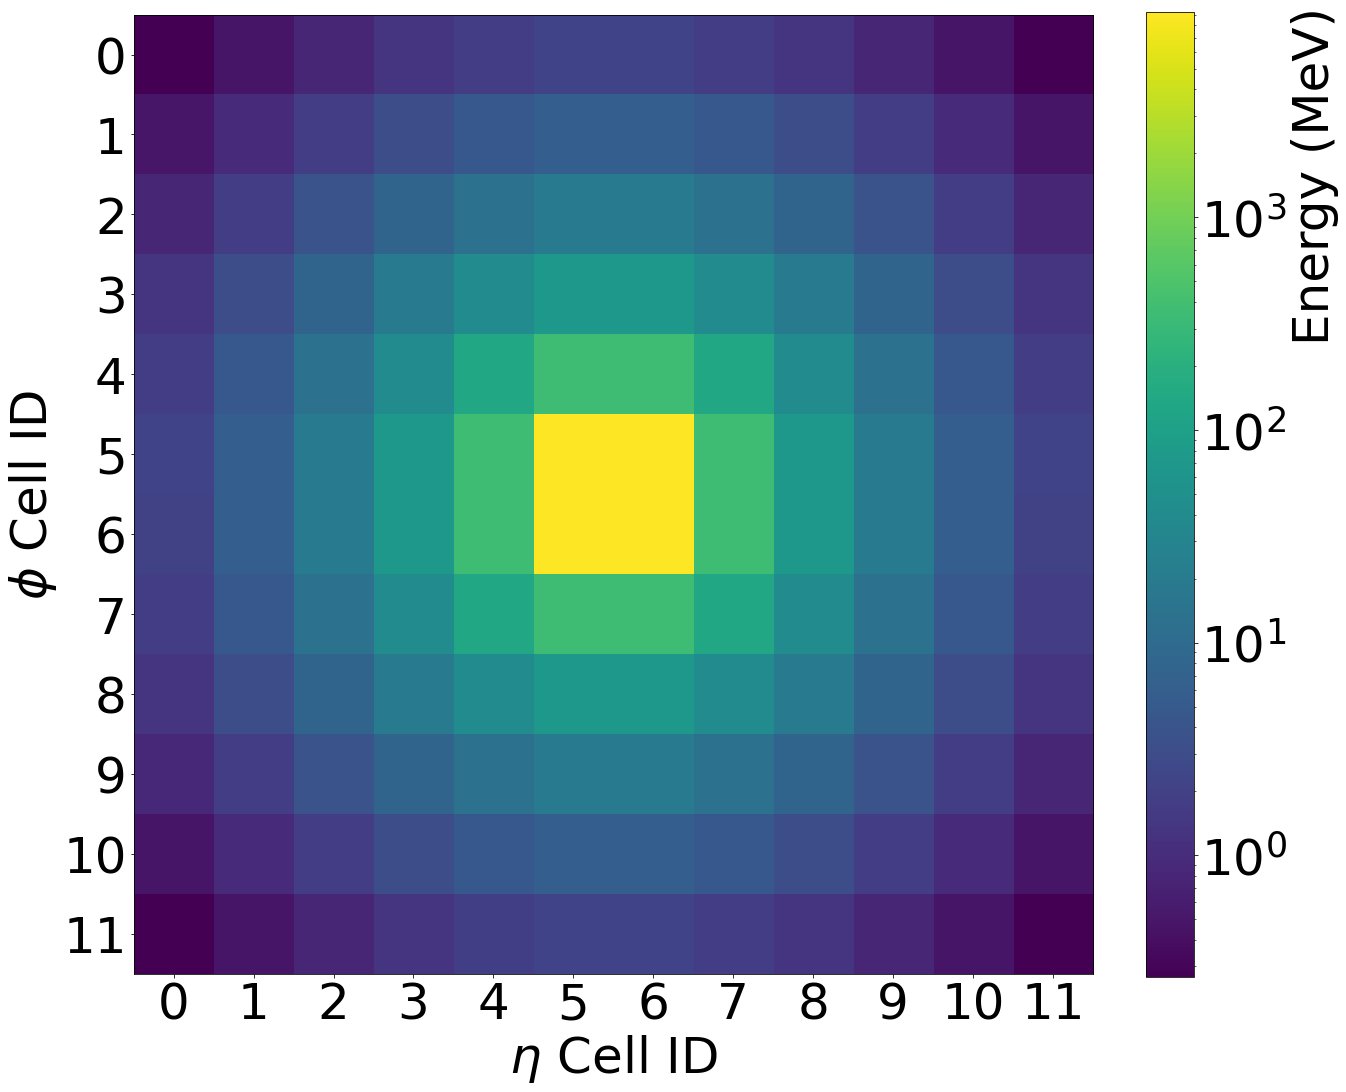

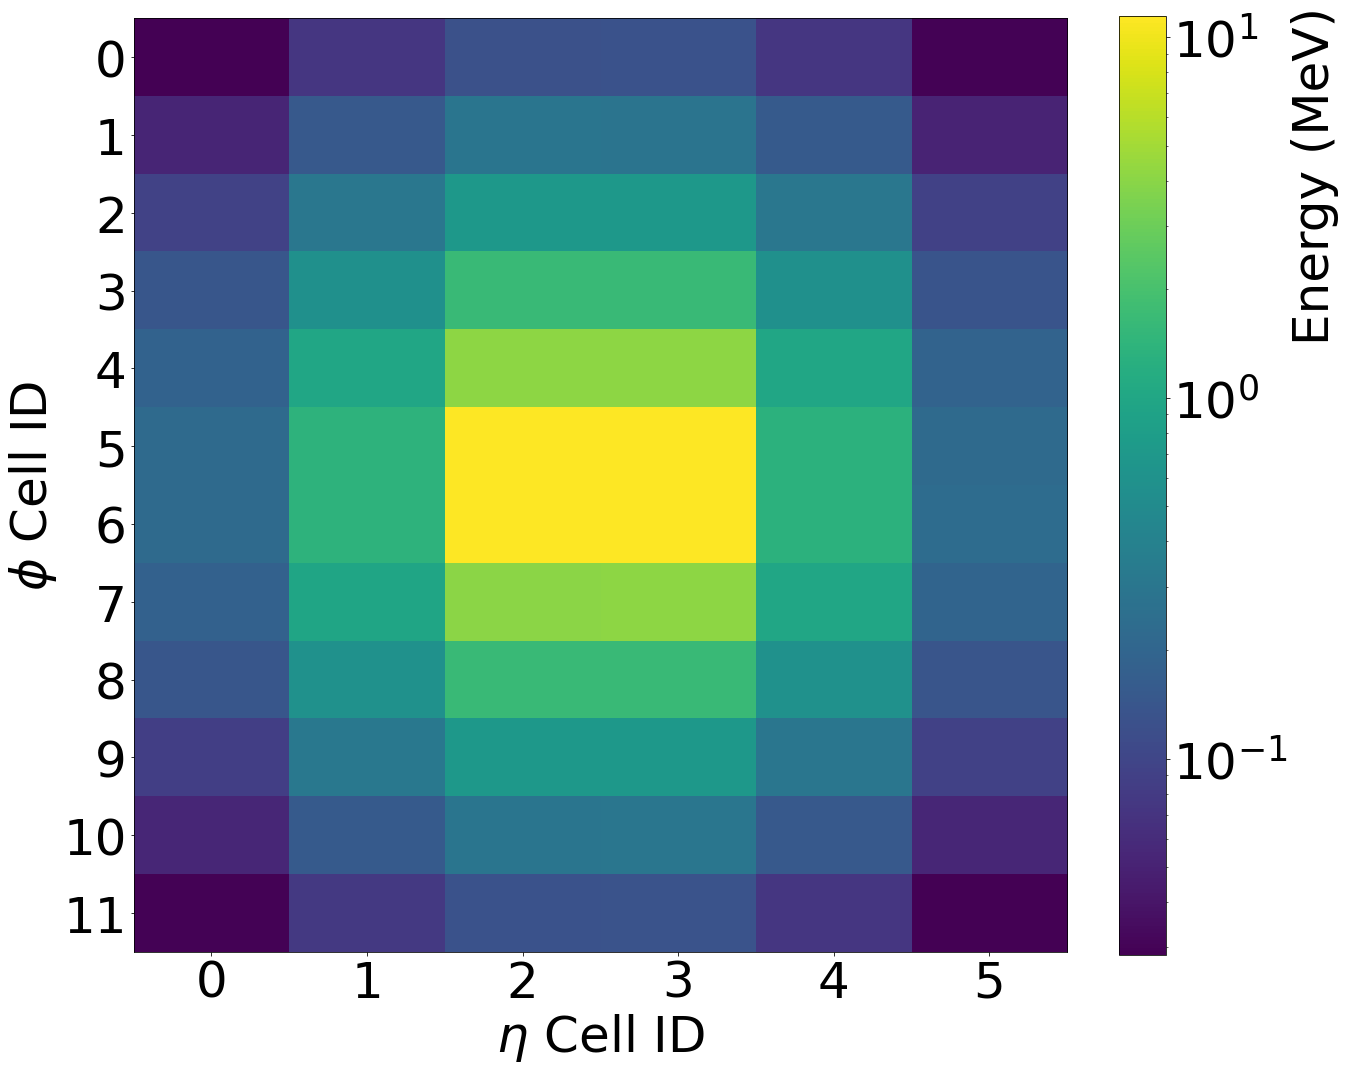

In [26]:
real_images_eplus = [eplus_0, eplus_1, eplus_2]
for i in range(3):
    plot_image(np.squeeze(real_images_eplus[i][:70000]).mean(axis=0), layer=i)
    #plt.savefig('eplus_{}_geant.pdf'.format(i), transparent=True)

Now that we know what the average images look like in each layer, for both GAN and GEANT generated showers, we can do another qualitative test of performance. Specifically, we can pick 5 random images out of the training set and find their nearest neighbor in the synthesized datasets. This can help us visualize whether the generated images display the desired degree of diversity, as well as whether they are simply memorizing the training set or actually learning something interesting.

In [35]:
def plot_nn(layer, gen_images=gen_images_eplus, real_images=real_images_eplus, vmin=vmin, vmax=vmax, sizes=sizes, nparticles=5):
    '''
    vmin and vmax are the arrays defined above based on GEANT image ranges
    sizes is also defined above
    npartciles: (default=5), number of random showers to plot
    '''
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(1, metric='euclidean')
    nn.fit(gen_images[layer].reshape(gen_images[layer].shape[0], -1))
    f, axarr = plt.subplots(2, nparticles, figsize=(25, 10))
    particles = np.random.randint(low=0, high=real_images[layer].shape[0], size=nparticles)

    for i, sel in enumerate(particles):
        nbr = int(nn.kneighbors(real_images[layer][sel].ravel().reshape(1, -1))[-1])
        def _plot_im(n_row, images):
            im = axarr[n_row, i].imshow(images,
                                        interpolation='nearest',
                                        norm=LogNorm(vmin=vmin[layer], vmax=vmax[layer]),
                                        aspect=sizes[1+(layer*2)] / float(sizes[(0)+(layer*2)]),
                                       )
            axarr[n_row, i].tick_params(axis='both', which='both', bottom='off', top='off',
                                    left='off', right='off', labelbottom='off',
                                    labelleft='off')
            return im

        cnv = [_plot_im(*content) for content in enumerate([real_images[layer][sel], gen_images[layer][nbr]])]
    axarr[0][0].set_ylabel('GEANT')
    axarr[1][0].set_ylabel('GAN')
    cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
    cb = f.colorbar(cnv[0], cax=cax)
    cb.set_label(r'Energy (MeV)', y=0.73)
    #plt.savefig('nn{}.pdf'.format(layer), pad_inches=2, transparent=True, bbox_inches='tight')

/home/tdhttt/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


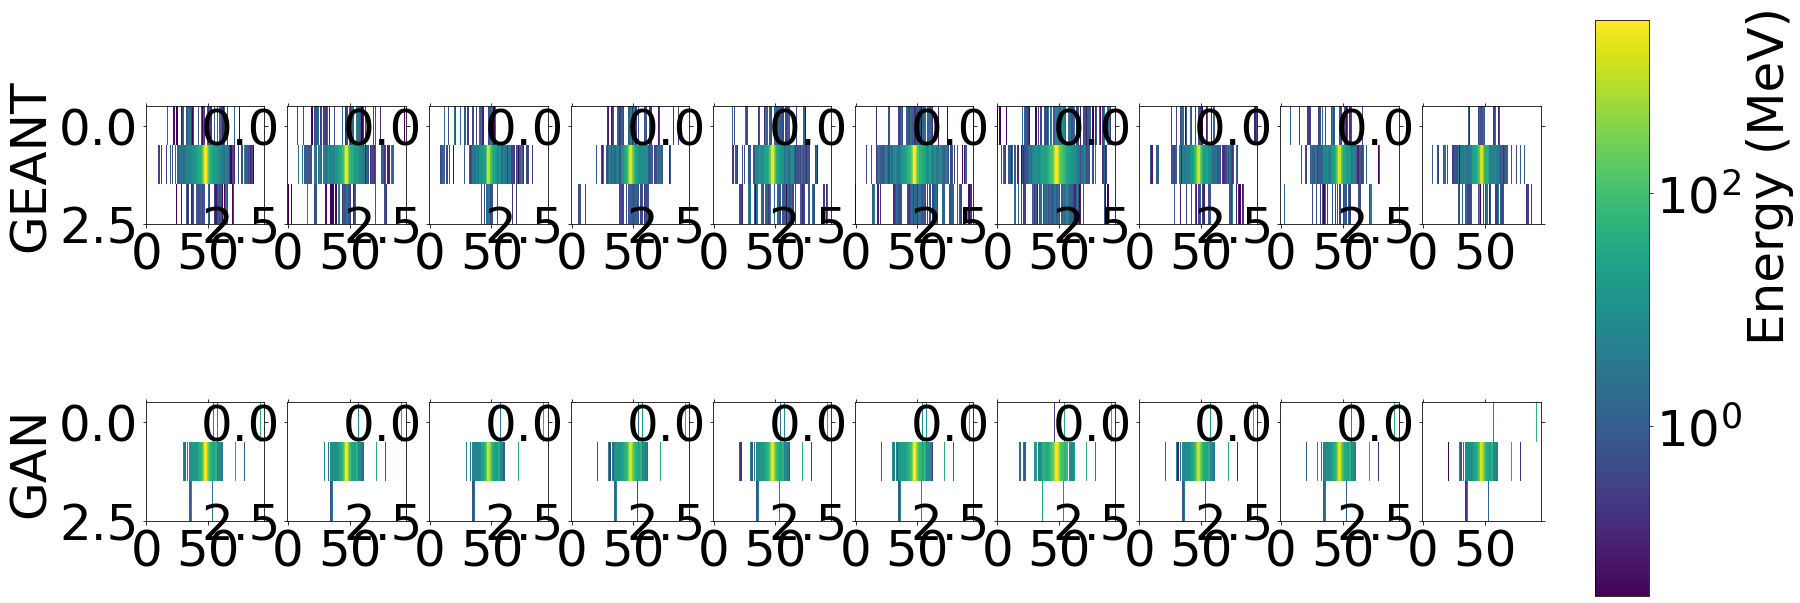

In [36]:
plot_nn(layer=0, nparticles=10)

/home/tdhttt/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


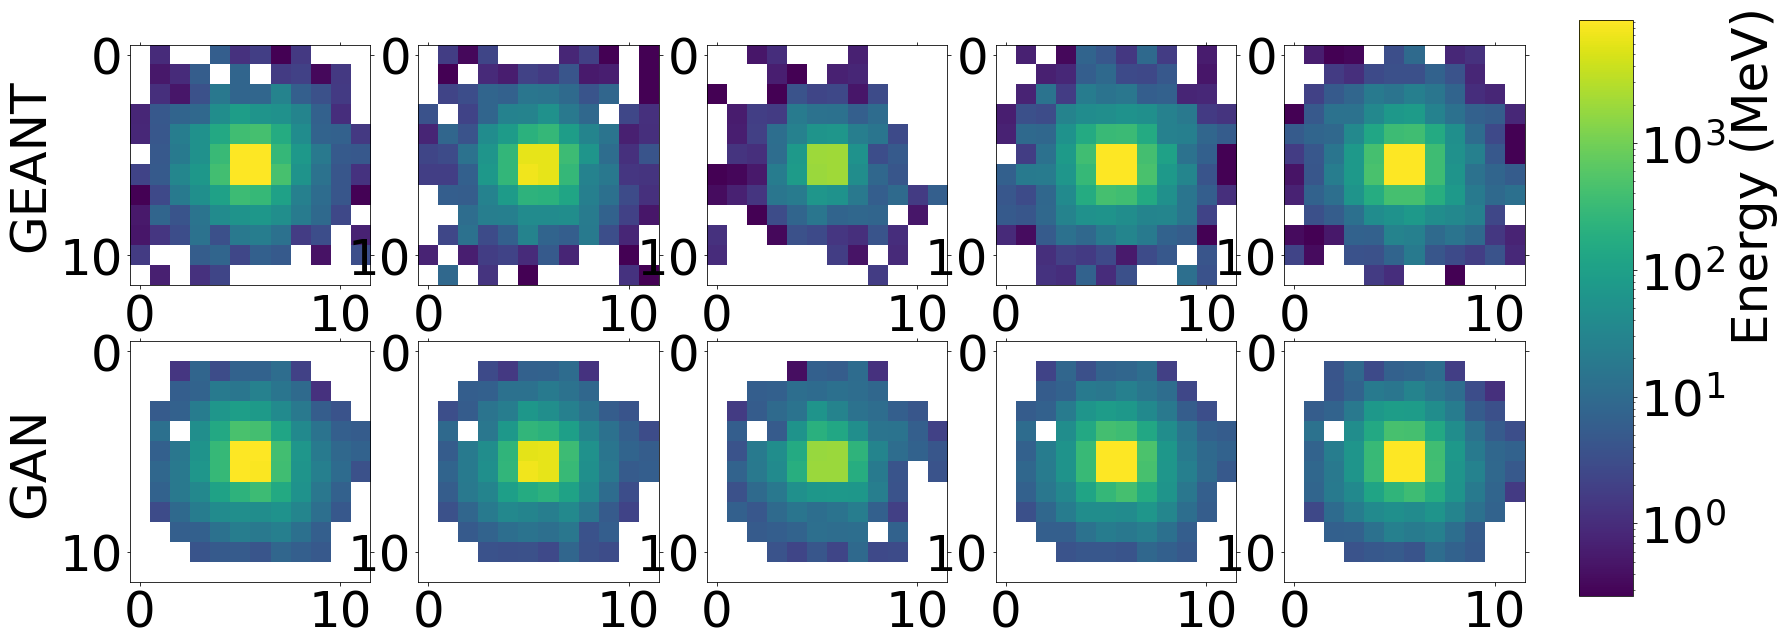

In [37]:
plot_nn(layer=1)

/home/tdhttt/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


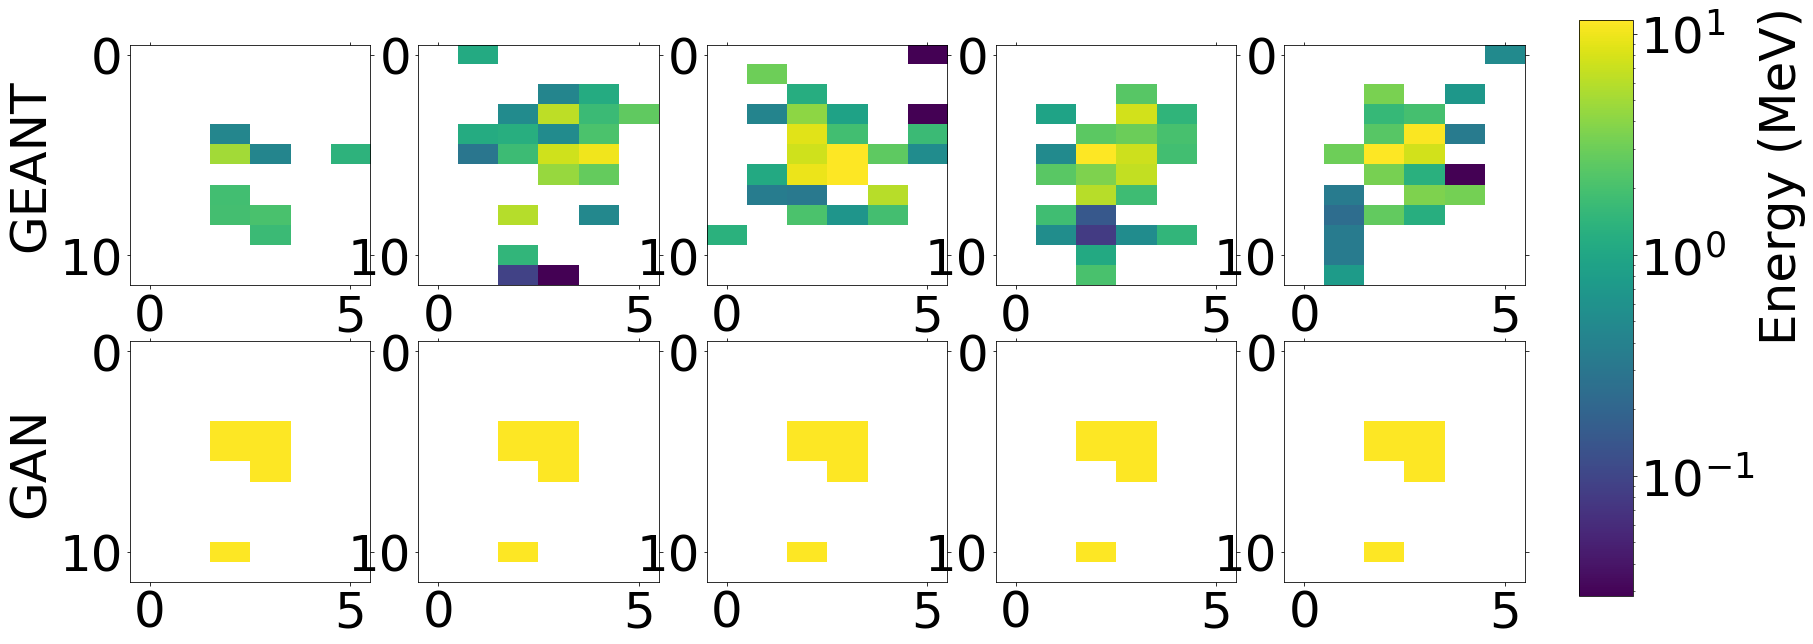

In [38]:
plot_nn(layer=2)

If we want to, we can do the same exact thing with other particle types, just by loading the correct weights into the generator, then repeating the plotting steps above.

# QC-AAN Sample Generation

In [41]:
%cd ../QC-CaloGAN/models/
from architectures import build_generator, build_discriminator,  sparse_softmax
from ops import scale, inpainting_attention
from qcbm import qcbm_approx_probs, initialize_weights, train_qcbm
%cd ../../notebooks/

/home/tdhttt/workspace/QC-UCI/QHack/QC-CaloGAN/models
/home/tdhttt/workspace/QC-UCI/QHack/notebooks


In [15]:
nb_qubits = 8
qcbm_nb_layers = 7
latent_size = 2**nb_qubits

In [11]:
from tensorflow.keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D, multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [12]:
# input placeholders
latent = Input(shape=(latent_size, ), name='z') # noise
input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
generator_inputs = [latent, input_energy]

# multiply the (scaled) energy into the latent space
h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# build three LAGAN-style generators (checkout out `build_generator` in architectures.py)
img_layer0 = build_generator(h, 3, 96)
img_layer1 = build_generator(h, 12, 12)
img_layer2 = build_generator(h, 12, 6)

# inpainting
# 0 --> 1
zero2one = AveragePooling2D(pool_size=(1, 8))(
    UpSampling2D(size=(4, 1))(
        img_layer0))
img_layer1 = inpainting_attention(img_layer1, zero2one) # this function is in ops.py
# 1 --> 2
one2two = AveragePooling2D(pool_size=(1, 2))(img_layer1)
img_layer2 = inpainting_attention(img_layer2, one2two)
# ^^ pooling and upsampling are needed to reshape images to same dimensions

# outputs
generator_outputs = [
    Activation('relu')(img_layer0),
    Activation('relu')(img_layer1),
    Activation('relu')(img_layer2)
]

In [13]:
# build the actual model
generator = Model(generator_inputs, generator_outputs)

In [14]:
# load trained weights
generator.load_weights('../QC-CaloGAN/models/weights/exp_qc_gen049.hdf5')

256


In [48]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [49]:
# sample noise from qcbm
qcbm_weights = initialize_weights(qcbm_nb_layers, nb_qubits)
# train QCBM with the discrimninator loss
# TODO: save weight for trained QCBM
dis_weights_f = h5py.File('../QC-CaloGAN/models/weights/exp_qc_dis049.hdf5', 'r')

/home/tdhttt/anaconda3/envs/qml/lib/python3.6/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return _np.array(args, *array_args, **array_kwargs)


In [50]:
qcbm_dis_weights = dis_weights_f['fakereal_output']['fakereal_output']['kernel:0'][:].flatten()
print("Train QCBM with the discrimninator loss")
qcbm_weights = train_qcbm(sigmoid(qcbm_dis_weights), qcbm_weights) 
dis_weights_f.close()

noise = qcbm_approx_probs(qcbm_weights, nb_qubits)
noise = np.array([i for i in noise.values()])
noise = np.concatenate((noise,np.zeros(latent_size-noise.size)))
noise = np.tile(noise, (10000, 1))
sampled_energy = np.random.uniform(1, 100, (10000, 1))

Train QCBM with the discrimninator loss
True Cost: 708.1488129890245
True Cost: 701.2807293574635
True Cost: 706.3637318536013


In [51]:
images = generator.predict([noise, sampled_energy], verbose=True)

313/313 [==============================] - 4s 13ms/step


In [52]:
# we need to multiply images by 1000 to match order of magnitude of generated images to real images
nimages = [np.squeeze(np.array(i) * 1000) for i in images]
#images = map(lambda x: np.squeeze(x * 1000), images)
vmin = [eplus_0.mean(axis=0).min(), eplus_1.mean(axis=0).min(), eplus_2.mean(axis=0).min()]
vmax = [eplus_0.mean(axis=0).max(), eplus_1.mean(axis=0).max(), eplus_2.mean(axis=0).max()]

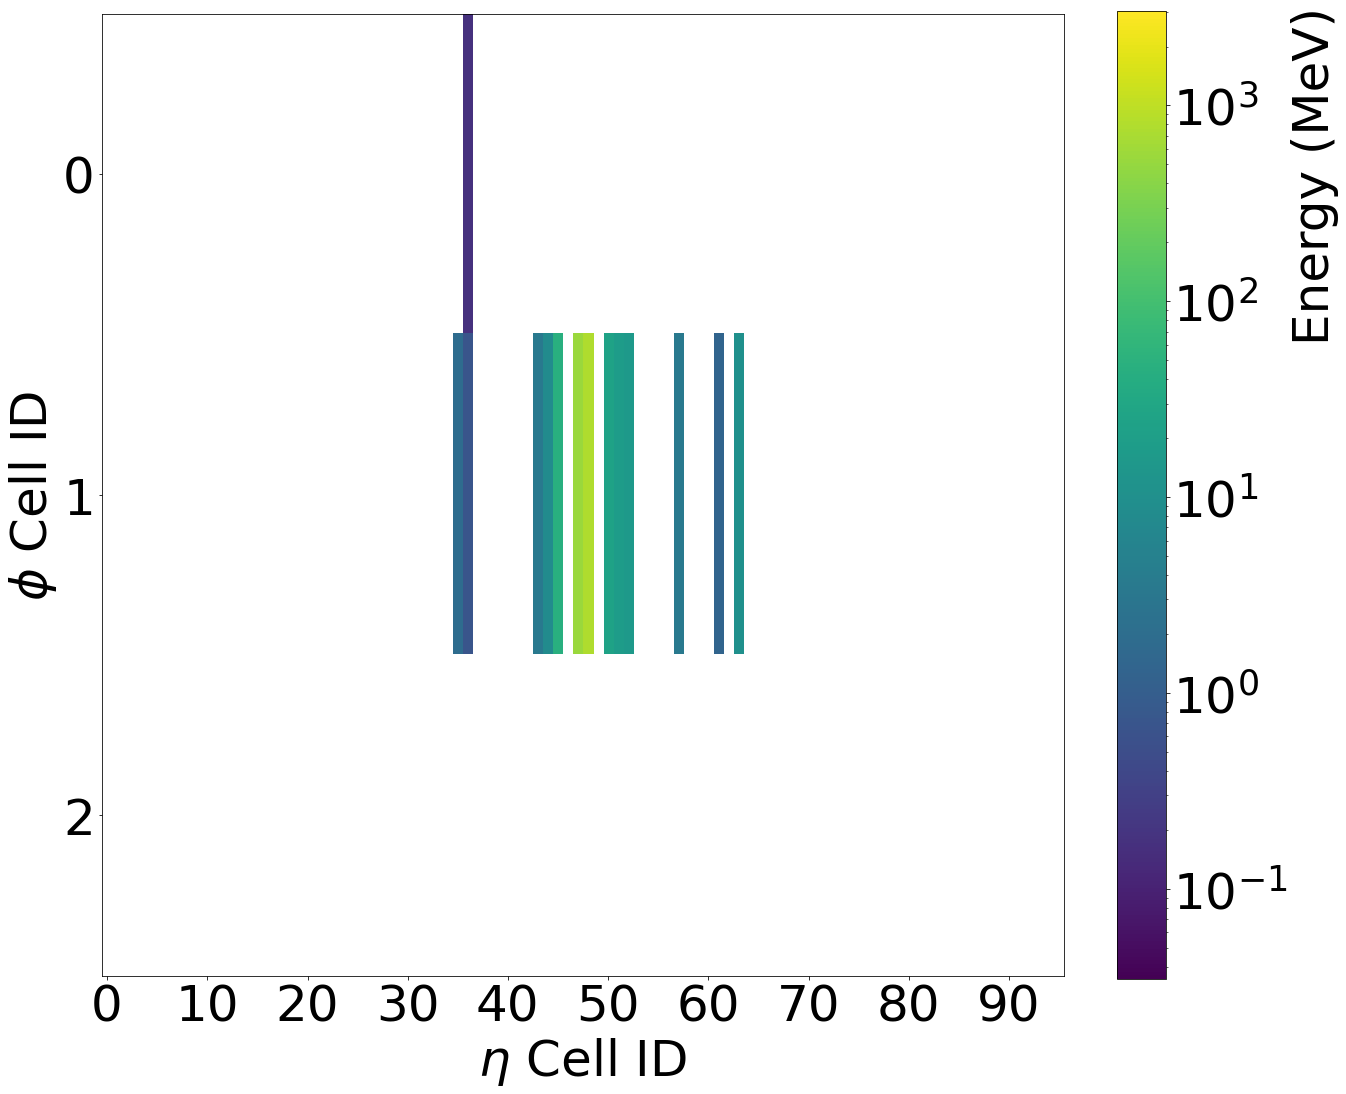

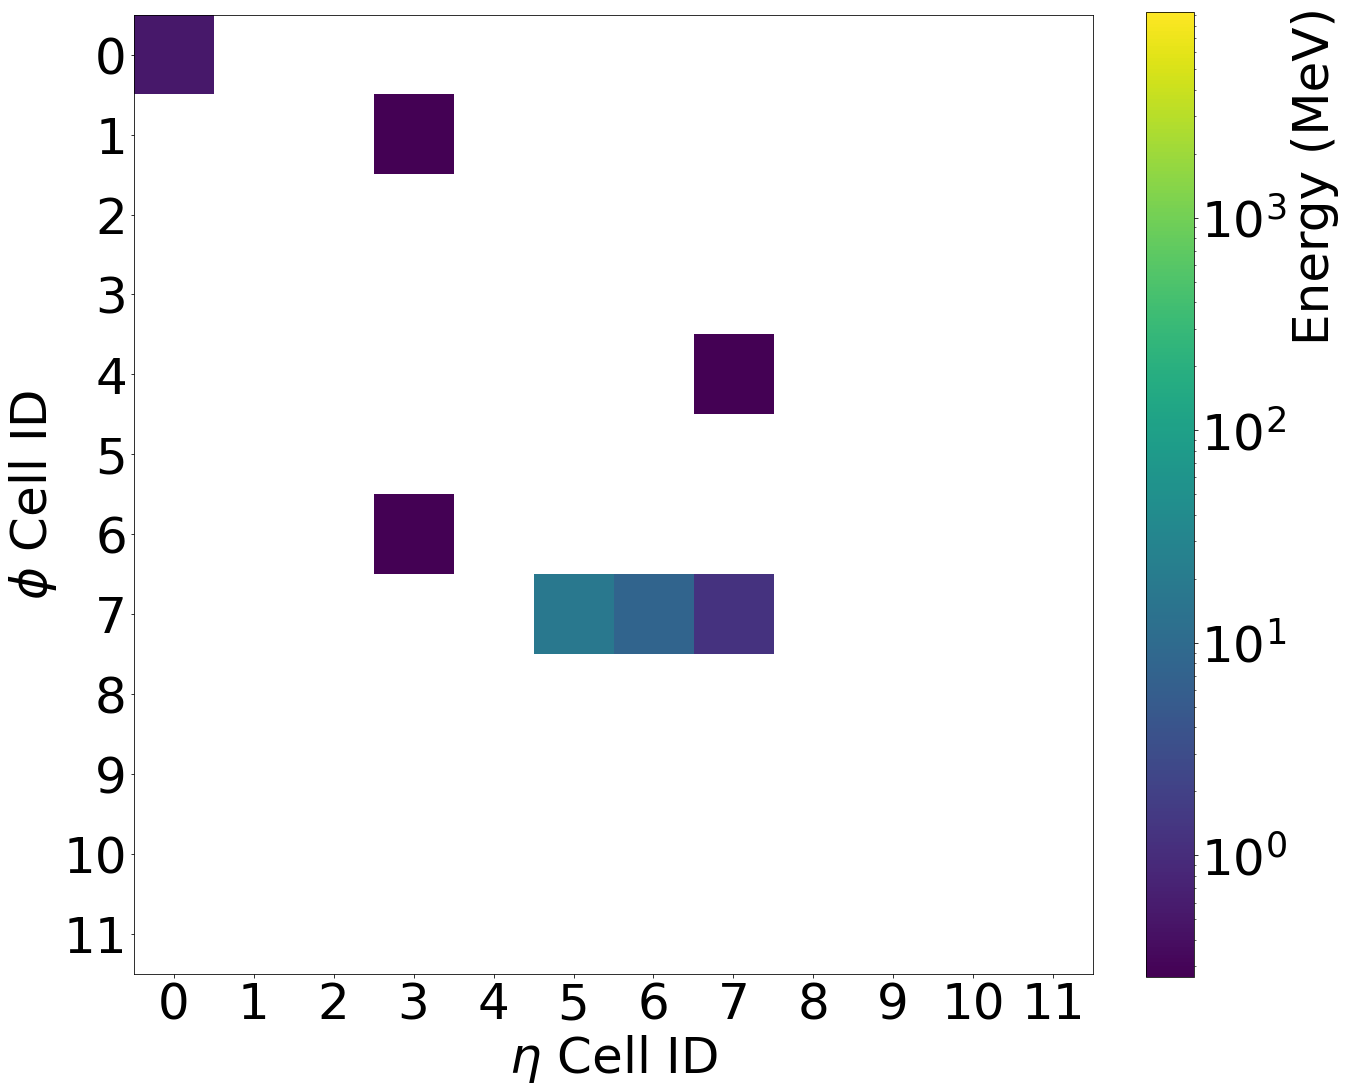

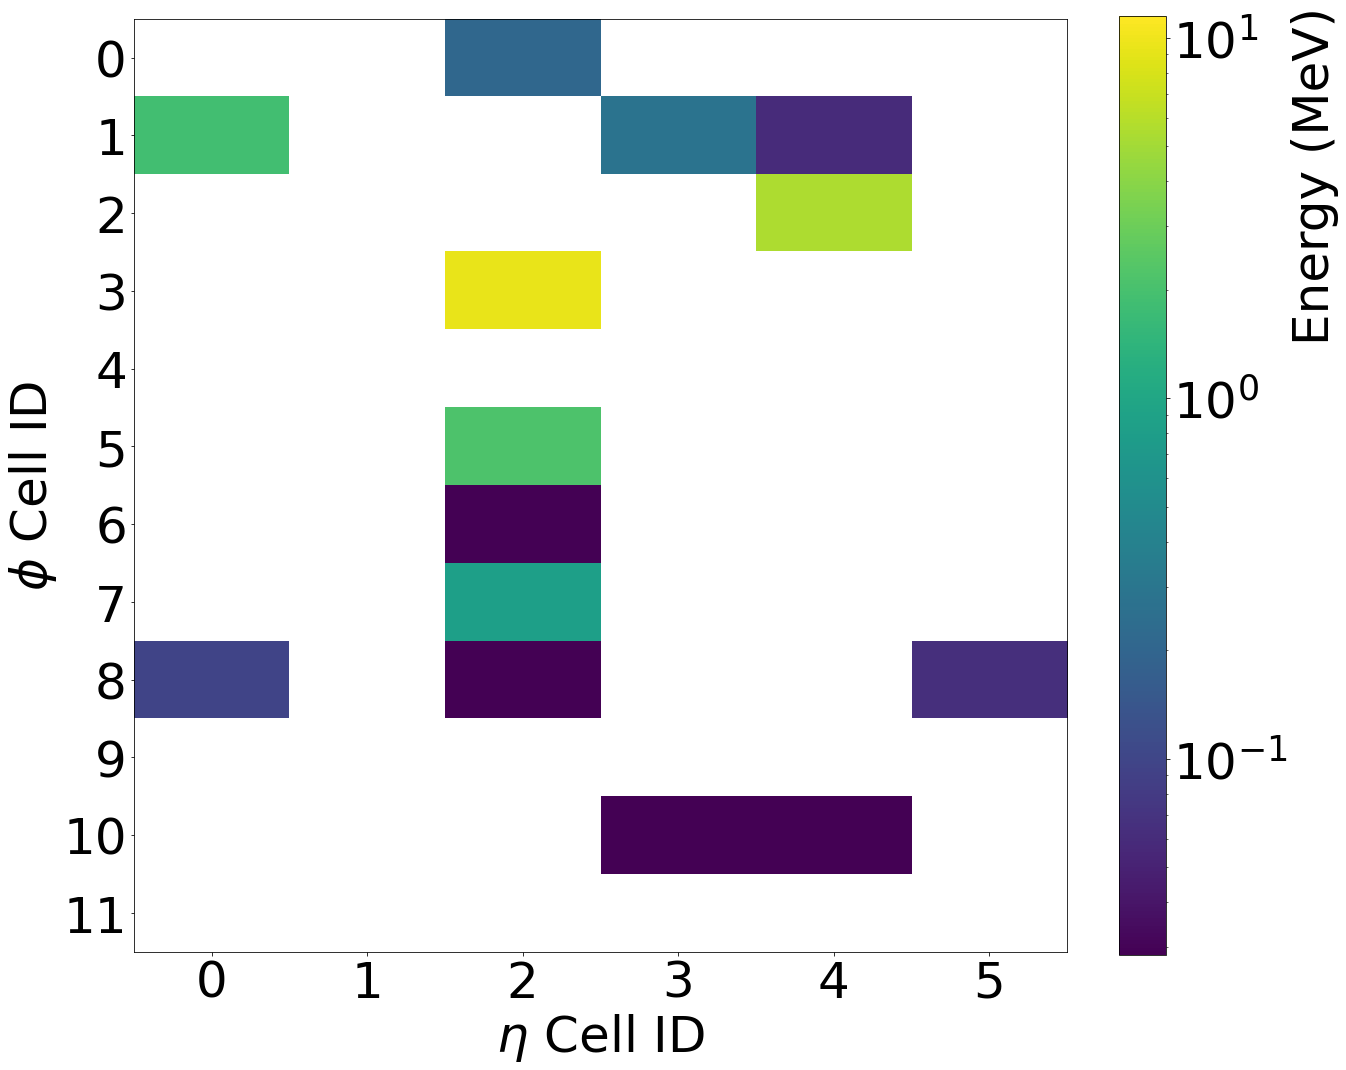

In [53]:
gen_images_eplus = [nimages[0], nimages[1], nimages[2]]
for i in range(3):
    plot_image(np.squeeze(gen_images_eplus[i]).mean(axis=0),
               layer=i,
               vmin=vmin[i],
               vmax=vmax[i]
    )

/home/tdhttt/anaconda3/envs/qml/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


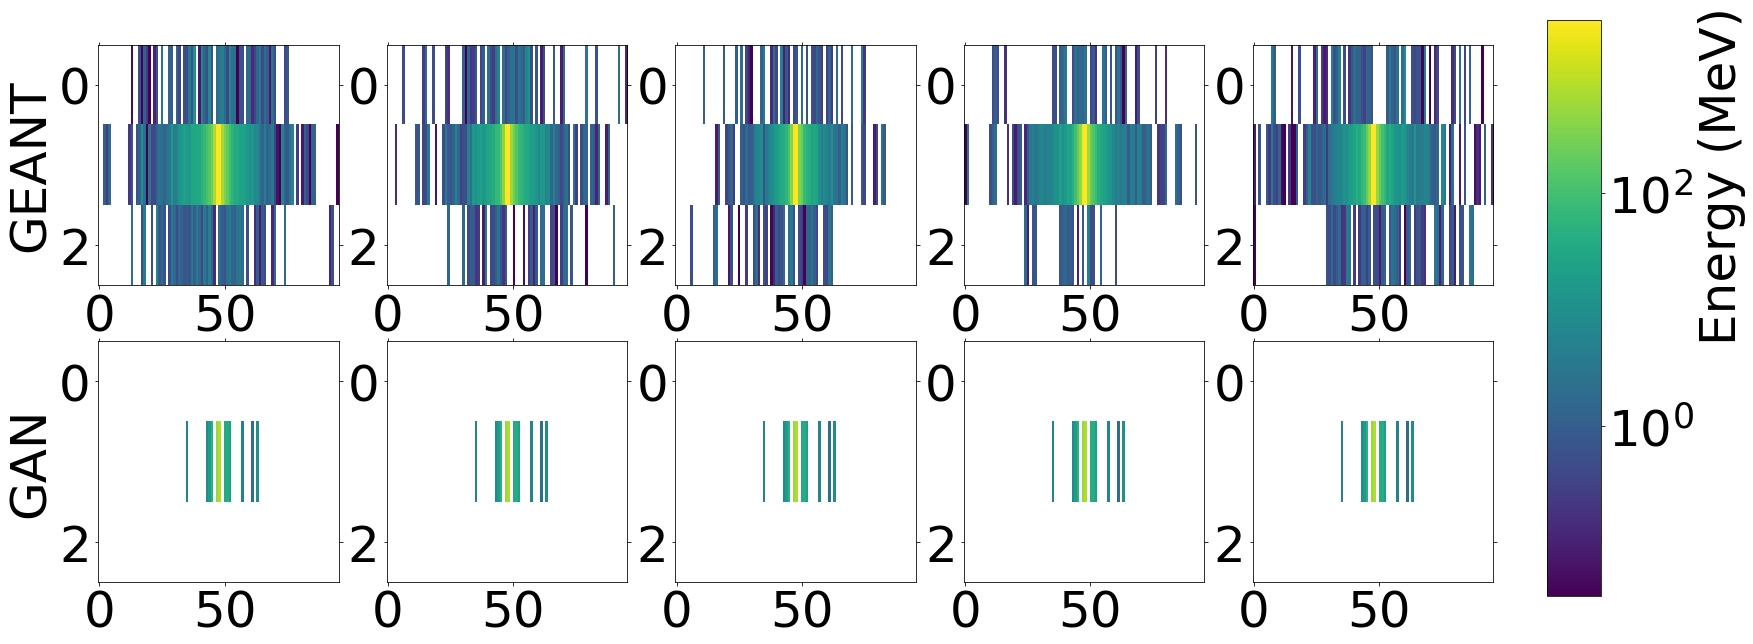

In [54]:
plot_nn(layer=0)

/home/tdhttt/anaconda3/envs/qml/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


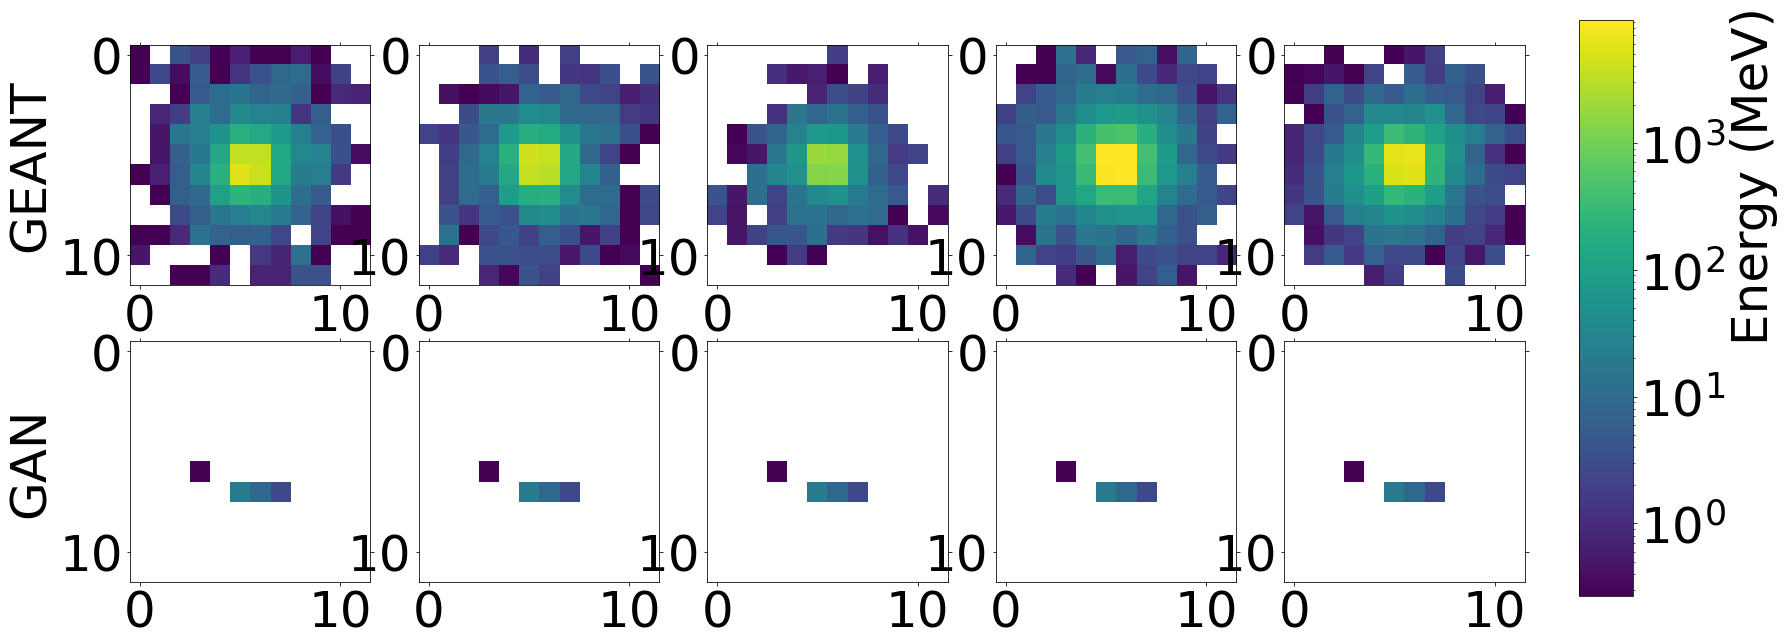

In [55]:
plot_nn(layer=1)

/home/tdhttt/anaconda3/envs/qml/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


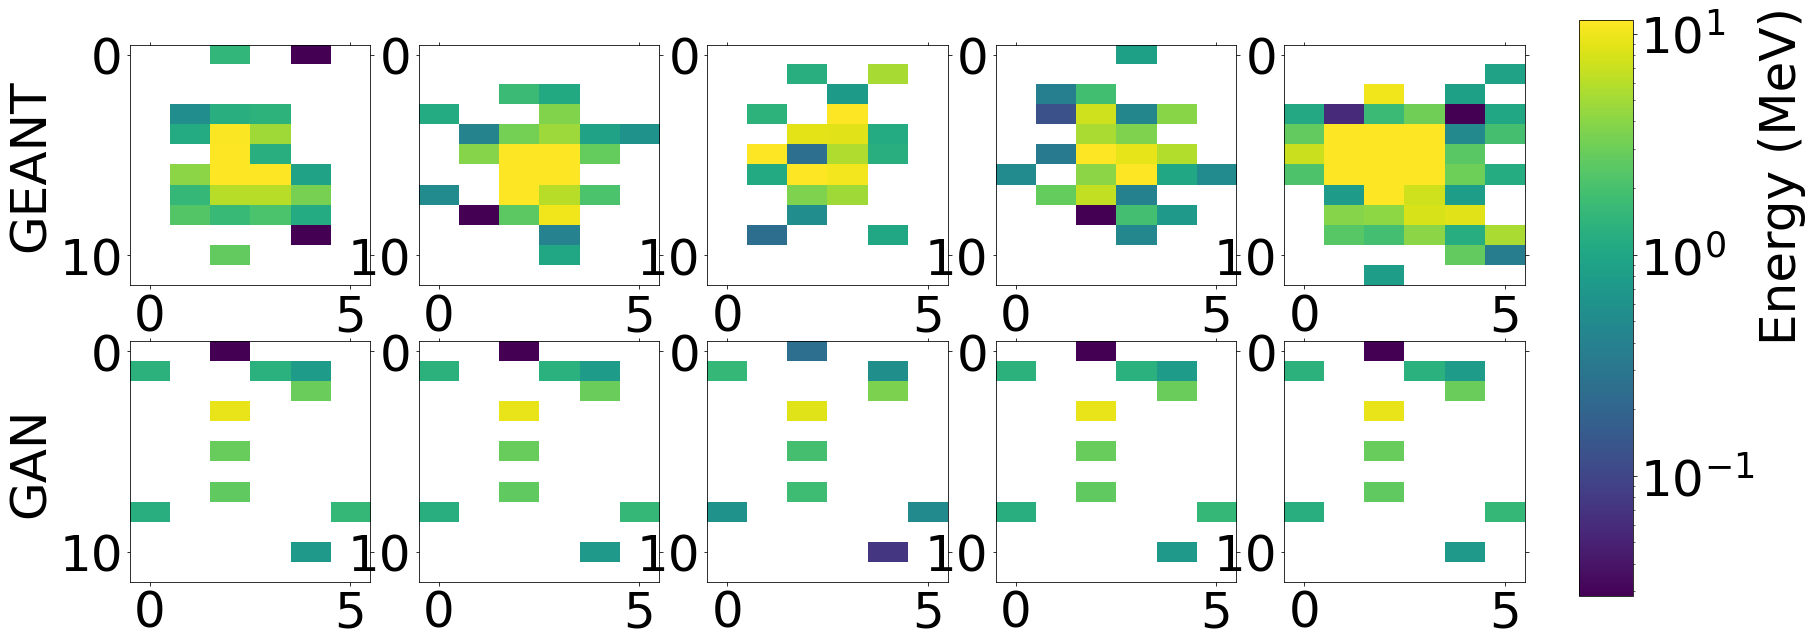

In [56]:
plot_nn(layer=2)